In [1]:
from importlib.metadata import version

import tiktoken
import torch 

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.1.2
tiktoken version: 0.6.0


In [4]:
import os
import requests

pdf_path = "constitution-of-india.pdf"

if not os.path.exists(pdf_path):
    print("File doesnt exist")
else:
    print(f"file {pdf_path} exists.")

file constitution-of-india.pdf exists.


In [5]:
#PDF to text  1. PyMuPDF  2. fitz
import pymupdf #pdf -> text 


def OpenAndReadPdf(pdf_path):
    """
    Opens a pdf file , reads its text content page by page, and collects statistics.

    Params: 
        pdf_path(str): The file path to the PDF documents to be opened and read.

    Returns:
        list[dict] : A list of dictionaries, each containing the page number (adjusted),
        character count, word count, sentence count, token count, and the extracted text for each page
    """
    doc = pymupdf.open(pdf_path)
    pages_and_texts = []
    for page_number, page in enumerate(doc):
        text = page.get_text()
        text = text.replace("\n", " ")
        pages_and_texts.append({"page_number": page_number - 30, 
                                "page_char_count": len(text),
                                #"page_word_count": len(text).split(" "),
                                "page_Sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text)/4 , #1token = ~4 chars
                                "text":text})

        return pages_and_texts

    
pages_and_texts = OpenAndReadPdf(pdf_path=pdf_path)
pages_and_texts[:2]

[{'page_number': -30,
  'page_char_count': 188,
  'page_Sentence_count_raw': 1,
  'page_token_count': 47.0,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING '}]

In [6]:
doc = pymupdf.open(pdf_path)
raw_text = ""
for page in doc:
    raw_text += page.get_text()
    #print(text)

In [53]:
len(doc)

402

In [7]:
f= open("constitution-of-india.txt", "a")
f.write(raw_text)
f.close()

In [8]:
with open(r".\constitution-of-india.txt", 'r', encoding='utf-8') as f:
    raw_text = f.read()

In [9]:
print('no of characters:', len(raw_text))
print(raw_text[55:99])

no of characters: 1740383
E CONSTITUTION
C.O. 273
In exercise of the p


In [10]:
type(raw_text)

str

## **Sample text for tokenizer**

In [11]:
import re 
text = "hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [12]:
result = re.split(r'([,.]|\s)', text)
print(result)

['hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [13]:
result = [items for items in result if items.strip()]
print(result)

['hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [14]:
text = 'The Constitution (One Hundredth Amendment) Act, 2015'

result = re.split(r'([,.;:"()\'_!?]|--|\s)', text)
result = [item for item in result if item.split()]
print(result)

['The', 'Constitution', '(', 'One', 'Hundredth', 'Amendment', ')', 'Act', ',', '2015']


## **Preprocessing**

In [15]:
preprocessed = re.split(r'([,.?:;"()\'_!]|--|\s)', raw_text)
preprocessed = [item for item in preprocessed if item.split()]
print(preprocessed[:30])

['371', 'APPENDIX', 'III', '1DECLRATION', 'UNDER', 'ARTICLE', '370', '(', '3', ')', 'OF', 'THE', 'CONSTITUTION', 'C', '.', 'O', '.', '273', 'In', 'exercise', 'of', 'the', 'powers', 'conferred', 'by', 'clause', '(', '3', ')', 'of']


In [16]:
print(len(preprocessed))

381073


### Convert tokens into token IDs

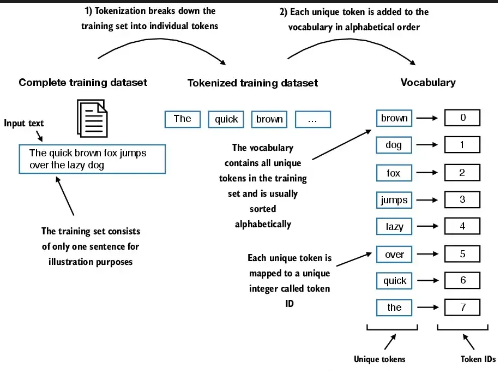

In [17]:
#from the preprocessed text, we can now build a vocabulary that consists of all the unique tokens

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

6812


In [26]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [19]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('"', 0)
('&', 1)
("'", 2)
('(', 3)
(')', 4)
('*', 5)
('**', 6)
('****', 7)
('**Entry', 8)
('*11', 9)
('*7', 10)
('*Now', 11)
('*Puducherry', 12)
('*Sadar-I-Riyasat', 13)
('*]', 14)
('*]]', 15)
('*four', 16)
(',', 17)
('-', 18)
('.', 19)
('/', 20)
('0', 21)
('000', 22)
('01', 23)
('02', 24)
('03-01-1977', 25)
('04', 26)
('05', 27)
('07', 28)
('09', 29)
('1', 30)
('1*', 31)
('1***', 32)
('1***]', 33)
('1-1-2004', 34)
('1-1-2007', 35)
('1-1-2016', 36)
('1-10-1959', 37)
('1-10-1968', 38)
('1-10-2006', 39)
('1-10-2013', 40)
('1-11-', 41)
('1-11-1956', 42)
('1-11-1966', 43)
('1-11-1973', 44)
('1-11-1986', 45)
('1-11-2000', 46)
('1-11-2011', 47)
('1-12-1963', 48)
('1-2-1977', 49)
('1-2-1992', 50)


### Sample text - Tokenizing - Vocab - Token ID

In [20]:
class SimpleTokenizerV1:

    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

* The `encode` function turns text into token IDs
* the `decode` function turns token IDs back to text

In [21]:
tokenizer = SimpleTokenizerV1(vocab)

text = """The Constitution (One Hundredth Amendment) Act, 2015 
            containing details of acquired and transferred territories 
            between the Governments of India and Bangladesh has been 
            provided in Appendix I."""

ids = tokenizer.encode(text)
print(ids)

[2924, 1728, 3, 2485, 2086, 1467, 4, 1426, 17, 572, 3830, 4022, 5202, 3202, 3351, 6310, 6208, 3534, 6222, 2036, 5202, 2127, 3351, 1549, 4572, 3516, 5563, 4662, 1490, 2090, 19]


In [22]:
tokenizer.decode(ids)

'The Constitution( One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in Appendix I.'

### Adding special context tokens

- add some "special tokens for unknown words and to denote the end of a text
- [BOS] - Beginning of Sequence
- [EOS] - End of Sequence - used to concatenate multiple unrelated texts.
- [PAD] - Padding - we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have equal lengths
- [UNK] - rep works that are not included in the vocab
- 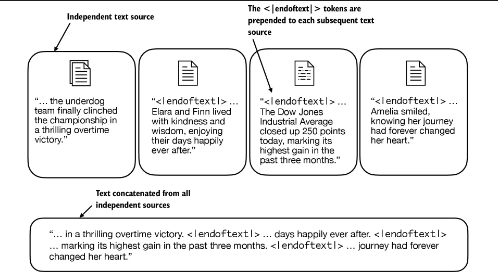

In [23]:
tokenizer = SimpleTokenizerV1(vocab)
text = "Hello, do you like tea, Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

In [29]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])


vocab = {token:integer for integer, token in enumerate(all_tokens)}


In [30]:
len(vocab.items())

6814

In [32]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('…', 6809)
('……', 6810)
('………', 6811)
('<|endoftext|>', 6812)
('<|unk|>', 6813)


In [33]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self,text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [ item if item in self.str_to_int
                         else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [34]:
tokenizer = SimpleTokenizerV2(vocab)
text1 = "Hello, do you like Coffee?"
text2 = "Would you like to join for lunch."

text = "<|endoftext|>".join((text1, text2))

print(text)

Hello, do you like Coffee?<|endoftext|>Would you like to join for lunch.


In [35]:
tokenizer.encode(text)

[6813,
 17,
 4123,
 6813,
 4916,
 6813,
 6813,
 6813,
 6813,
 4916,
 6280,
 6813,
 4442,
 6813,
 19]

In [36]:
tokenizer.decode(tokenizer.encode(text))


'<|unk|>, do <|unk|> like <|unk|> <|unk|> <|unk|> <|unk|> like to <|unk|> for <|unk|>.'

### **BytePain Encoding**